In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import deque

# Load Data

In [2]:
%%time

file = 'data/1030_IQ_10s_FRA_1.bin'

raw = np.fromfile(file, dtype=np.int16).reshape(-1, 2)
iq = pd.DataFrame(raw, columns=['I', 'Q'])
iq['IQ'] = iq.I + 1j*iq.Q
iq['phase'] = np.angle(iq['IQ'])
iq['power'] = np.square(iq.I.astype(np.int32)) + np.square(iq.Q.astype(np.int32)) 
iq['amplitude'] = np.sqrt(iq.power) / 2897

# convert power to dBFS
iq['dBFS'] = np.nan
m = iq.power > 0
iq.loc[m, 'dBFS'] = 10*np.log10(iq.power[m])

# add time dimension
iq['t'] = np.arange(0, len(iq)) / 12e6 # 12 Msamples/s

iq.sample()

CPU times: user 15 s, sys: 2.64 s, total: 17.7 s
Wall time: 17.7 s


,I,Q,IQ,phase,power,amplitude,dBFS,t
42462758,-14,6,-14.0+ 6.0j,2.736701,232,0.005258,23.65488,3.538563


In [3]:
sample_time = 1/12e6

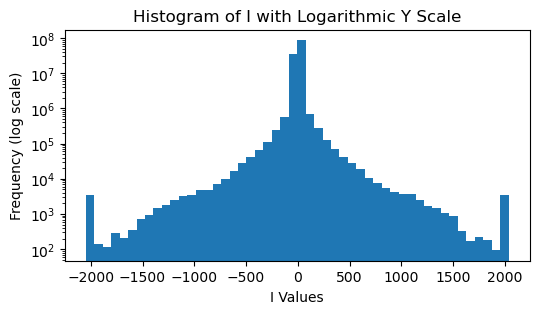

In [4]:
plt.figure(figsize=(6,3))
plt.hist(iq['I'], bins=50)
plt.yscale('log')
plt.xlabel('I Values')
plt.ylabel('Frequency (log scale)')
plt.title('Histogram of I with Logarithmic Y Scale')
plt.show()

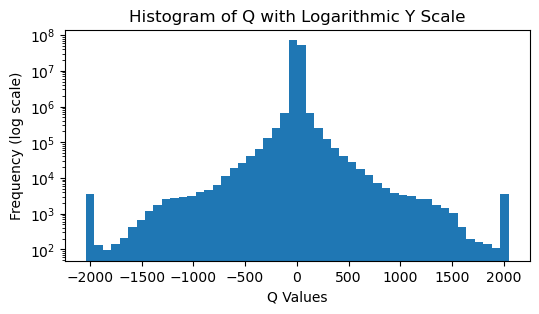

In [5]:
plt.figure(figsize=(6,3))
plt.hist(iq['Q'], bins=50)
plt.yscale('log')
plt.xlabel('Q Values')
plt.ylabel('Frequency (log scale)')
plt.title('Histogram of Q with Logarithmic Y Scale')
plt.show()

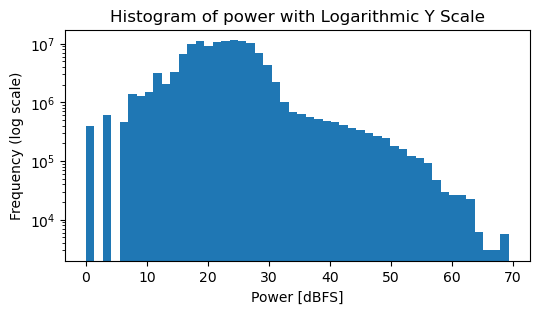

In [6]:
plt.figure(figsize=(6,3))
plt.hist(iq.dBFS, bins=50)
plt.yscale('log')
plt.xlabel('Power [dBFS]')
plt.ylabel('Frequency (log scale)')
plt.title('Histogram of power with Logarithmic Y Scale')
plt.show()

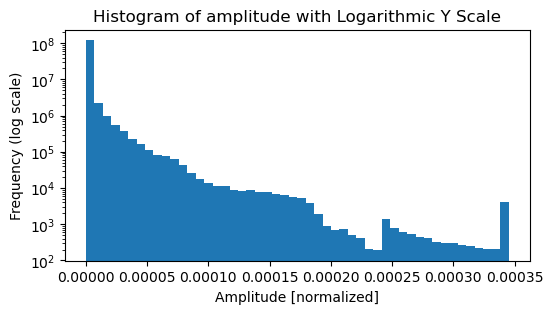

In [7]:
# 2897 = sqrt(2028**2 + 2048**2) = max amplitude
plt.figure(figsize=(6,3))
plt.hist(iq.amplitude / 2897, bins=50)
plt.yscale('log')
plt.xlabel('Amplitude [normalized]')
plt.ylabel('Frequency (log scale)')
plt.title('Histogram of amplitude with Logarithmic Y Scale')
plt.show()

# Time Domain Examples

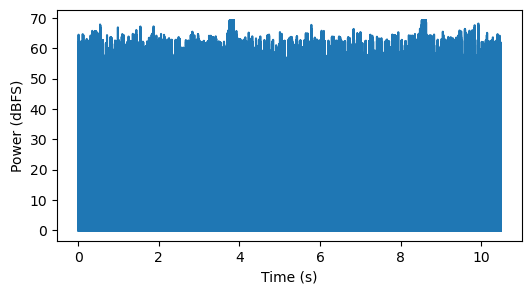

In [8]:
plt.figure(figsize=(6,3))
plt.plot(iq.t, iq.dBFS)
plt.xlabel('Time (s)')
plt.ylabel('Power (dBFS)')
plt.show()

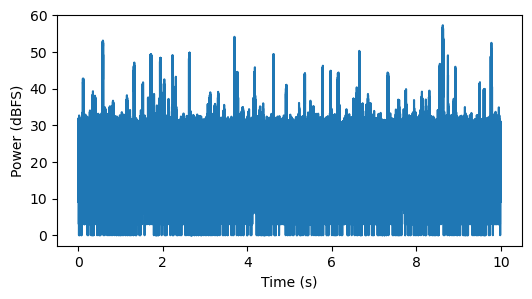

In [9]:
# zoom in to the first 10 ms
m = iq.t < 10/1000

plt.figure(figsize=(6,3))
plt.plot(iq.t[m]*1000, iq.dBFS[m])
plt.xlabel('Time (s)')
plt.ylabel('Power (dBFS)')
plt.show()

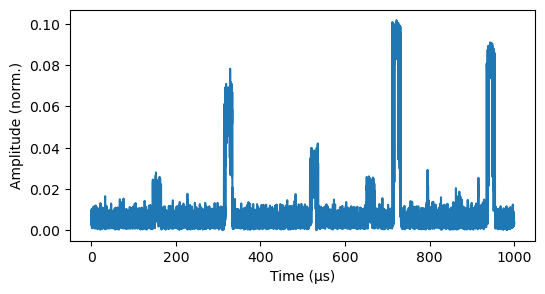

In [10]:
def plotTimeDomain(startMs, endMs):
    m = (startMs/1000 < iq.t) & (iq.t < endMs/1000)
    normalized_time = (iq.t[m] - startMs/1_000) * 1_000_000
    plt.figure(figsize=(6,3))
    plt.plot(normalized_time, iq.amplitude[m])
    plt.xlabel('Time (µs)')
    plt.ylabel('Amplitude (norm.)')
    plt.show()

plotTimeDomain(1, 2)

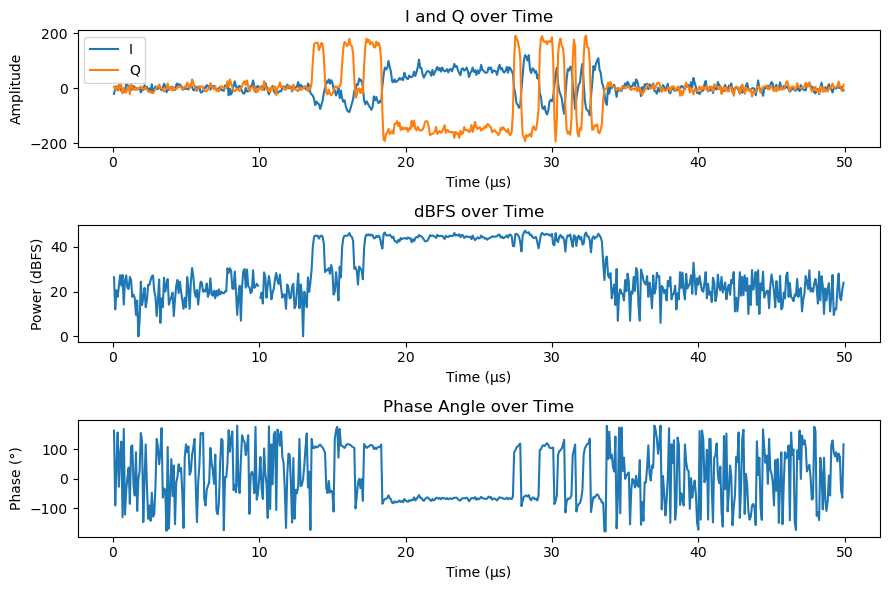

In [11]:
def plotTimeRange(startMs, endMs):
    m = (startMs/1000 < iq.t) & (iq.t < endMs/1000)
    normalized_time = (iq.t[m] - startMs/1_000) * 1_000_000
    
    plt.figure(figsize=(9, 6))
    
    plt.subplot(3, 1, 1)
    plt.plot(normalized_time, iq.I[m], label='I')
    plt.plot(normalized_time, iq.Q[m], label='Q')
    plt.xlabel('Time (µs)')
    plt.ylabel('Amplitude')
    plt.title('I and Q over Time')
    plt.legend()
    
    plt.subplot(3, 1, 2)
    plt.plot(normalized_time, iq.dBFS[m])
    plt.xlabel('Time (µs)')
    plt.ylabel('Power (dBFS)')
    plt.title('dBFS over Time')
    
    plt.subplot(3, 1, 3)
    plt.plot(normalized_time, np.rad2deg(iq.phase[m]))
    plt.xlabel('Time (µs)')
    plt.ylabel('Phase (°)')
    plt.title('Phase Angle over Time')
    
    plt.tight_layout()
    plt.show()

plotTimeRange(1.3, 1.35)

# Signal Detection

1. Detect the Start of Transmission: Identify points where the amplitude exceeds the threshold T for N consecutive samples.
2. Determine the Amplitude A: Find the highest point in the amplitude following the start of the transmission.
3. Detect the End of Transmission: Identify points where the amplitude stays below A/2 or above 2A for X out of M consecutive samples.
4. Measure the rise time defined as twice the time between the point where the signal first crosses A/2 until it reaches A.

In [12]:
# configuration
T = iq.amplitude.quantile(0.95) # amplitude threshold for detection (95-th percentile)
N = 10
M = 3*N
X = 0.9*M

TdB = 20*np.log10(T*2897)
TdB

np.float64(32.90924559382754)

In [13]:
iq.amplitude.quantile([0.9, 0.95, 0.99])

0.90    0.010105
0.95    0.015259
0.99    0.082018
Name: amplitude, dtype: float64

In [14]:
%%time

# detect transmission starts (N)
start_condition = np.where(np.convolve(iq['amplitude'] > T, np.ones(N, dtype=int), mode='valid') >= N)[0]
start_condition = deque(start_condition)

# detect transmission ends (X out of M)
end_condition = np.where(np.convolve(iq['amplitude'] < T, np.ones(M, dtype=int), mode='valid') >= X)[0]
end_condition = deque(end_condition)

detectionIdx = dict()
i = start_condition.popleft()
j = end_condition.popleft()
while len(start_condition) > 0 and len(end_condition) > 0:
    # find next end
    while len(end_condition) > 0 and j <= i: j = end_condition.popleft()

    if len(end_condition) == 0: break
    
    # store pair
    detectionIdx[len(detectionIdx)] = (i, j)
    
    # find next start
    while len(start_condition) > 0 and i <= j: i = start_condition.popleft()


len(detectionIdx)

CPU times: user 43.3 s, sys: 2.53 s, total: 45.9 s
Wall time: 46.2 s


35277

In [15]:
%%time

detections = pd.DataFrame.from_dict(detectionIdx, orient='index', columns=['startIdx', 'endIdx'])
detections['durationUs'] = (detections['endIdx'] - detections['startIdx']) * sample_time * 1_000_000

def calculate_level(row):
    global iq
    start_idx = int(row['startIdx'])
    end_idx = int(row['endIdx'])
    return np.percentile(iq['amplitude'].iloc[start_idx:end_idx+1], 95)

def calculate_level_dB(row):
    global iq
    start_idx = int(row['startIdx'])
    end_idx = int(row['endIdx'])
    return np.percentile(iq['dBFS'].iloc[start_idx:end_idx+1], 95)

detections['level'] = detections.apply(calculate_level, axis=1)
detections['levelDB'] = detections.apply(calculate_level_dB, axis=1)

detections

CPU times: user 12.9 s, sys: 3.86 ms, total: 12.9 s
Wall time: 12.9 s


,startIdx,endIdx,durationUs,level,levelDB
0,1331,1568,19.750000,0.043476,42.003879
1,4093,4270,14.750000,0.027131,37.907914
2,4743,4853,9.166667,0.024316,36.955883
3,6855,7098,20.250000,0.146153,52.535127
4,13839,13976,11.416667,0.023415,36.628701
...,...,...,...,...,...
35272,125818521,125818672,12.583333,0.024193,36.912899
35273,125819475,125819644,14.083333,0.023445,36.640116
35274,125821816,125822052,19.666667,0.117873,50.667260
35275,125825045,125825281,19.666667,0.051634,43.497605


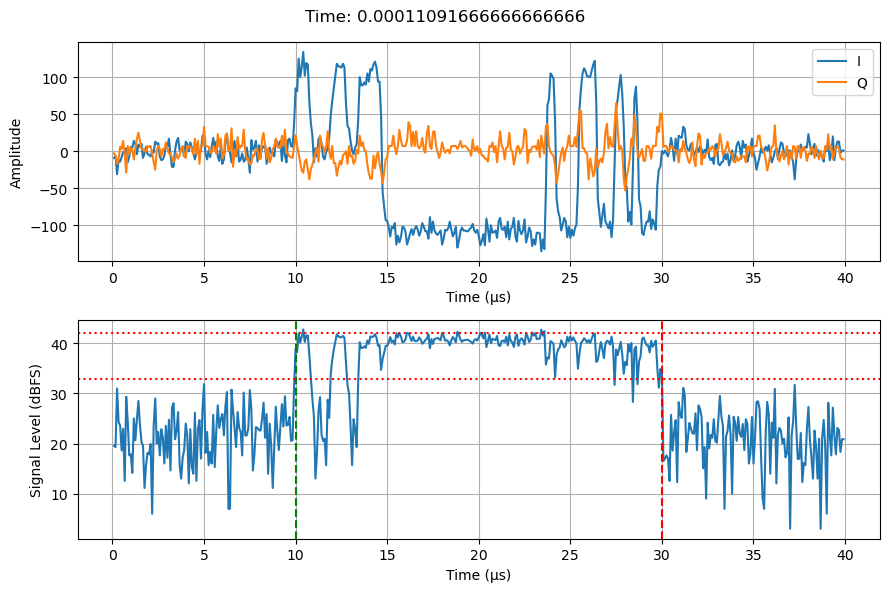

In [16]:
def getDetectionSamples(i):
    startMs = iq.t.iloc[detections.startIdx.iloc[i]] * 1_000 - 0.010
    endMs = (iq.t.iloc[detections.endIdx.iloc[i]] + (M-X)*sample_time) * 1_000 + 0.010
    m = (startMs/1000 < iq.t) & (iq.t < endMs/1000)
    return iq[m]

def plotDetection(i):
    startMs = iq.t.iloc[detections.startIdx.iloc[i]] * 1_000 - 0.010
    endMs = (iq.t.iloc[detections.endIdx.iloc[i]] + (M-X)*sample_time) * 1_000 + 0.010
    
    m = (startMs/1000 < iq.t) & (iq.t < endMs/1000)
    normalized_time = (iq.t[m] - startMs/1_000) * 1_000_000  # Convert to µs
    
    plt.figure(figsize=(9, 6))
    
    plt.subplot(2, 1, 1)
    plt.plot(normalized_time, iq.I[m], label='I')
    plt.plot(normalized_time, iq.Q[m], label='Q')
    plt.xlabel('Time (µs)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(2, 1, 2)
    plt.plot(normalized_time, iq.dBFS[m])
    plt.xlabel('Time (µs)')
    plt.ylabel('Signal Level (dBFS)')
    plt.grid(True)

    iStarts = np.where((detections.startIdx >= np.where(m)[0][0]) & (detections.startIdx <= np.where(m)[0][-1]))[0]
    for i in iStarts:
        startTimeMs = iq.t.iloc[detections.startIdx.iloc[i]] * 1_000
        plt.axvline((startTimeMs - startMs) * 1000, color='green', linestyle='--')
        
    iEnds = np.where((detections.endIdx >= np.where(m)[0][0]) & (detections.endIdx <= np.where(m)[0][-1]))[0]
    for i in iEnds:
        endTimeMs = (iq.t.iloc[detections.endIdx.iloc[i]] + (M-X)*sample_time) * 1_000
        plt.axvline((endTimeMs - startMs) * 1000, color='r', linestyle='--')

    plt.axhline(y=TdB, color='r', linestyle=':')
    plt.axhline(y=detections.levelDB.iloc[i], color='r', linestyle=':')
    
    #plt.subplot(3, 1, 3)
    #plt.plot(normalized_time, np.rad2deg(iq.phase[m]))
    #plt.xlabel('Time (µs)')
    #plt.ylabel('Phase (°)')
    #plt.title('Phase Angle over Time')
    #plt.grid(True)

    plt.suptitle(f'Time: {iq.t.iloc[detections.startIdx.iloc[i]]}')
    plt.tight_layout()
    plt.show()

# Plot the time range with vertical red lines for start indices
plotDetection(0)

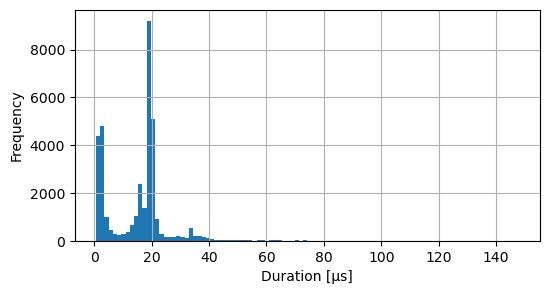

In [17]:
plt.figure(figsize=(6,3))
plt.hist(detections.durationUs, bins=100)
plt.xlabel('Duration [µs]')
plt.ylabel('Frequency')
plt.grid()
plt.show()

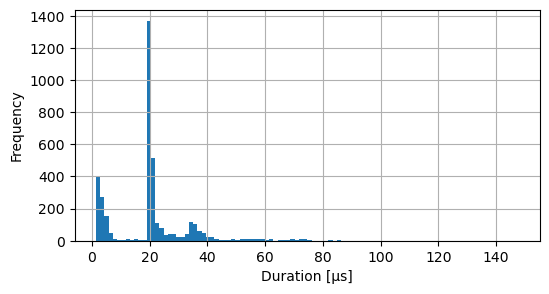

count    3755.000000
mean       20.338504
std        13.451354
min         1.416667
50%        20.166667
90%        36.000000
95%        41.525000
98%        58.980000
99%        70.166667
max       147.833333
Name: durationUs, dtype: float64

In [18]:
m = detections.levelDB - TdB > 20 # SNR in dB

plt.figure(figsize=(6,3))
plt.hist(detections.durationUs[m], bins=100)
plt.xlabel('Duration [µs]')
plt.ylabel('Frequency')
plt.grid()
plt.show()

detections.durationUs[m].describe(percentiles=[0.9, 0.95, 0.98, 0.99])

In [19]:
idc = np.where(detections.levelDB - TdB > 10)[0] # SNR in dB
#idc = np.where(detections.durationUs < 15)[0] # SNR in dB
i = -1
len(idc)

18592

startIdx      6855.000000
endIdx        7098.000000
durationUs      20.250000
level            0.146153
levelDB         52.535127
Name: 3, dtype: float64


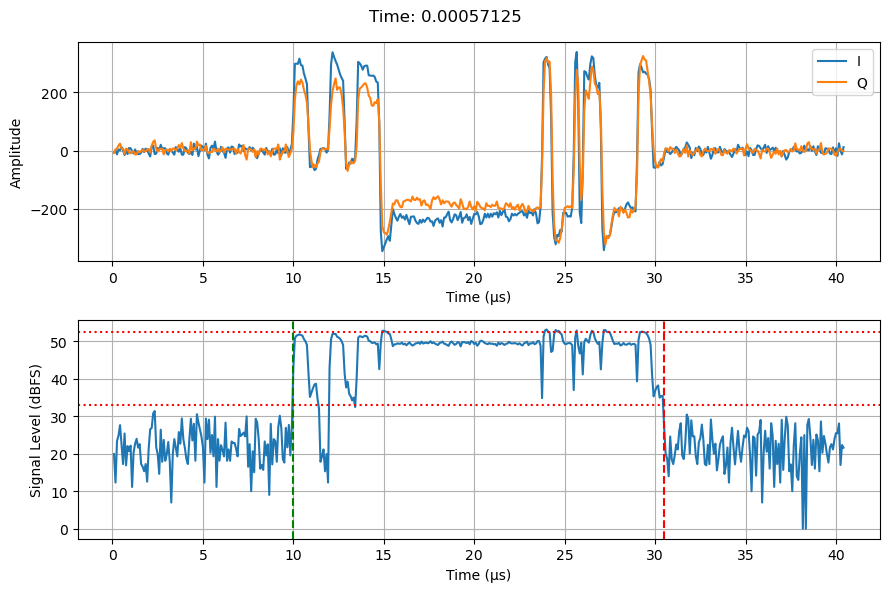

In [20]:
i += 1
print(detections.iloc[idc[i]])
plotDetection(idc[i])

Cross-correlating the signal with itself but with a slight delay of 100 samples:

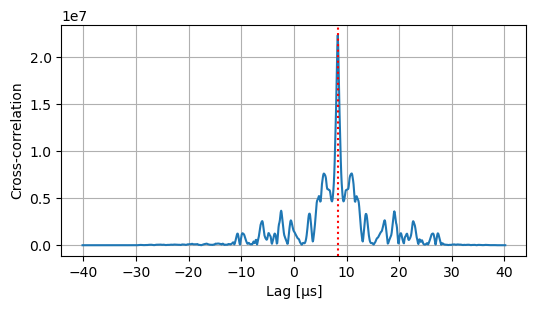

In [21]:
startIdx = int(detections.startIdx.iloc[idc[i]] - 0.000010 / sample_time)
endIdx = int(detections.endIdx.iloc[idc[i]] +  0.000010 / sample_time)

tmp1 = iq[startIdx:endIdx].copy()
tmp2 = iq[startIdx+100:endIdx+100].copy()

xcorrelation = np.correlate(tmp1['IQ'].values, tmp2['IQ'].values, mode='full')
lags = np.arange(-len(tmp1) + 1, len(tmp1)) * sample_time * 1e6

plt.figure(figsize=(6,3))
plt.plot(lags, np.abs(xcorrelation))
plt.axvline(100*sample_time*1e6, color='red', ls=':', label='expected')
plt.xlabel('Lag [µs]')
plt.ylabel('Cross-correlation')
plt.grid(True)
plt.show()

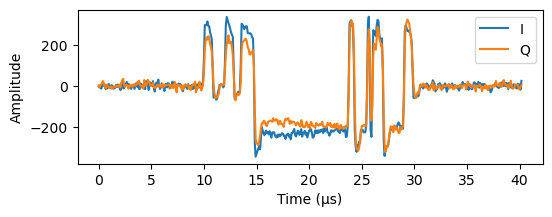

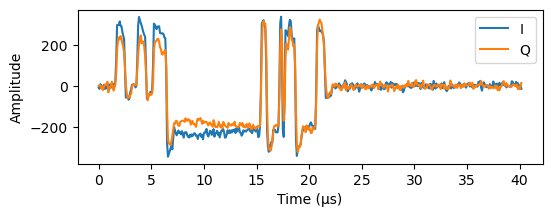

In [22]:
plt.figure(figsize=(6, 2))
plt.plot((tmp1.t - tmp1.t.min()) * 1e6, tmp1.I, label='I')
plt.plot((tmp1.t - tmp1.t.min()) * 1e6, tmp1.Q, label='Q')
plt.xlabel('Time (µs)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

plt.figure(figsize=(6, 2))
plt.plot((tmp1.t - tmp1.t.min()) * 1e6, tmp2.I, label='I')
plt.plot((tmp1.t - tmp1.t.min()) * 1e6, tmp2.Q, label='Q')
plt.xlabel('Time (µs)')
plt.ylabel('Amplitude')
plt.legend()

What if the other signal is 180° phase shifted?

In [23]:
tmp2.head()

,I,Q,IQ,phase,power,amplitude,dBFS,t
6835,-6,1,-6.0+ 1.0j,2.976444,37,0.002100,15.682017,0.00057
6836,-14,4,-14.0+ 4.0j,2.863293,212,0.005026,23.263359,0.00057
6837,9,3,9.0+ 3.0j,0.321751,90,0.003275,19.542425,0.00057
6838,-3,-13,-3.0-13.0j,-1.797595,178,0.004605,22.504200,0.00057
6839,-2,-2,-2.0- 2.0j,-2.356194,8,0.000976,9.030900,0.00057


In [24]:
tmp2['I'] = -tmp2['I']
tmp2['Q'] = -tmp2['Q']
tmp2['IQ'] = tmp2.I + 1j*tmp2.Q
tmp2['phase'] = np.angle(tmp2['IQ'])
tmp2.head()

,I,Q,IQ,phase,power,amplitude,dBFS,t
6835,6,-1,6.0- 1.0j,-0.165149,37,0.002100,15.682017,0.00057
6836,14,-4,14.0- 4.0j,-0.278300,212,0.005026,23.263359,0.00057
6837,-9,-3,-9.0- 3.0j,-2.819842,90,0.003275,19.542425,0.00057
6838,3,13,3.0+13.0j,1.343997,178,0.004605,22.504200,0.00057
6839,2,2,2.0+ 2.0j,0.785398,8,0.000976,9.030900,0.00057


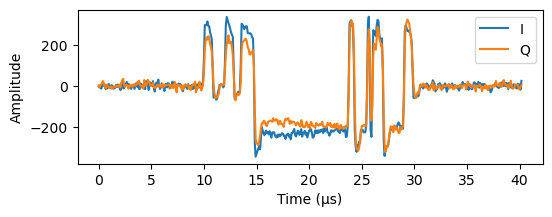

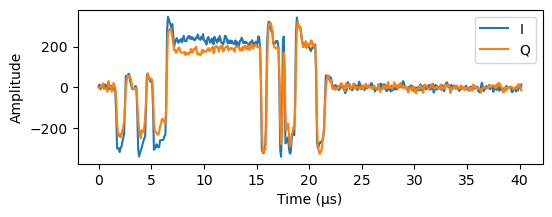

In [25]:
plt.figure(figsize=(6, 2))
plt.plot((tmp1.t - tmp1.t.min()) * 1e6, tmp1.I, label='I')
plt.plot((tmp1.t - tmp1.t.min()) * 1e6, tmp1.Q, label='Q')
plt.xlabel('Time (µs)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

plt.figure(figsize=(6, 2))
plt.plot((tmp1.t - tmp1.t.min()) * 1e6, tmp2.I, label='I')
plt.plot((tmp1.t - tmp1.t.min()) * 1e6, tmp2.Q, label='Q')
plt.xlabel('Time (µs)')
plt.ylabel('Amplitude')
plt.legend()

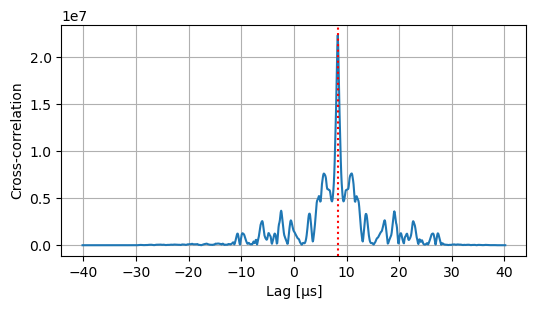

In [26]:
xcorrelation = np.correlate(tmp1['IQ'].values, tmp2['IQ'].values, mode='full')
lags = np.arange(-len(tmp1) + 1, len(tmp1)) * sample_time * 1e6

plt.figure(figsize=(6,3))
plt.plot(lags, np.abs(xcorrelation))
plt.axvline(100*sample_time*1e6, color='red', ls=':', label='expected')
plt.xlabel('Lag [µs]')
plt.ylabel('Cross-correlation')
plt.grid(True)
plt.show()

# Store Results

In [27]:
detections_file = file.removesuffix('.bin') + '_detections.csv.gz'
detections.to_csv(detections_file, compression='gzip')